In [19]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
import langevin
import lmfit as lm

In [2]:
# here we define the values of the physical parameters
# all energies are in kT = 4e-21J and lengths are in micrometers
# kappa = 10kT, sigma = 0.5 microJ/m^2, gamma = 0.1MJ/m^4, eta = 1.0mPa s
kappa = 10
sigma = 125
ga = 25
eta= 0.25
qmin=np.sqrt(3)/10

Here we describe the system in a continuous way

In [3]:
def gamma(q, kappa=kappa, sigma=sigma, ga=ga, eta=eta ):
    return (kappa*q**4+sigma*q**2+ga)/(4*eta*q)

In [4]:
def avg(q,resolution):
    return (np.exp(-gamma(q)*resolution)-1.0+gamma(q)*resolution)/(gamma(q)**2*resolution**2)

In [5]:
def integrant(q,t):
    return q*np.exp(-gamma(q)*t)/(kappa*q**4+sigma*q**2+ga)*avg(q,1e-6)*np.exp(-0.25*0.5**2*q**2)

In [6]:
time=np.logspace(-5,0,50)

In [7]:
acf=[quad(integrant,qmin,np.inf,args=(t))[0] for t in time]

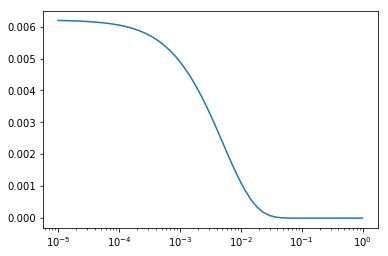

In [8]:
plt.semilogx(time,acf)

lets try the discrete one.  Here we assume that we have a $q_{min}$ and that $q^2=q_{x}^2+q_{y}^2$ where each $q_{x}=lq_{min}$ and $q_{y}=mq_{min}$ which results in $q_{lm}=q_{min}\sqrt{l^2+m^2}$

In [9]:
q_list=[np.sqrt(l**2+m**2) for l in range(0,4) for m in range(0,4)]

In [10]:
q_list=np.array(sorted(q_list)[1:])
print(q_list.size)
print(q_list)

15
[ 1.          1.          1.41421356  2.          2.          2.23606798
  2.23606798  2.82842712  3.          3.          3.16227766  3.16227766
  3.60555128  3.60555128  4.24264069]


In [11]:
def corrfct(t,q_list):
    corr=np.exp(-gamma(q_list)*t)/(kappa*q_list**4+sigma*q_list**2+ga)*avg(q_list,1e-6)*np.exp(-0.25*0.5**2*q_list**2)
    return corr.sum()

In [12]:
acf_d = np.array([corrfct(t,q_list) for t in time])

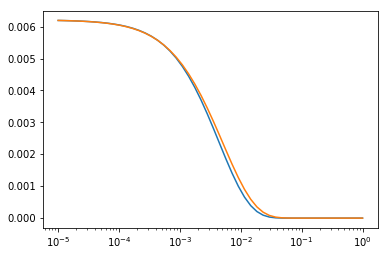

In [13]:
# plot correlation functions and normalize them to the same msd
plt.semilogx(time,acf_d*acf[0]/acf_d[0])
plt.semilogx(time,acf)

In [43]:
delta_t = 0.00001
def simulate_membrane(N):
    ts_all = None
    for q in q_list:
        ts = langevin.time_series2(1/(kappa*q**4+sigma*q**2+ga),gamma(q),delta_t,N)
    #    print(1/(kappa*q**4+sigma*q**2+ga),gamma(q))
        if ts_all is None:
            ts_all = ts
        else:
            ts_all = ts_all + ts
    return ts_all

ts_all=simulate_membrane(10000)

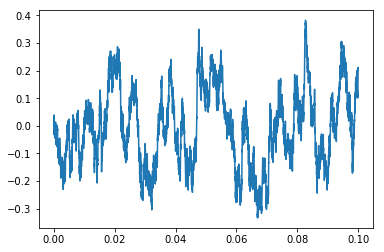

In [44]:
plt.plot(np.arange(ts_all.size)*delta_t,ts_all)

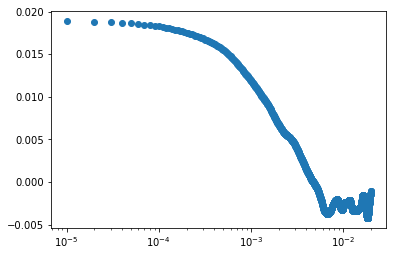

In [48]:
N = ts_all.size
# calculate autocorrelation function
f = np.fft.rfft(ts_all)
acf = np.fft.irfft(f * np.conjugate(f))
acf = np.fft.fftshift(acf) / N
autocorr = acf[int(N / 2):]

autocorr = autocorr[:2000]
t = np.arange(autocorr.size)*delta_t
plt.semilogx(t, autocorr,"o")

In [27]:
def fitcorr(t,kappa,sigma,ga,eta):
    corr=[np.sum(np.exp(-gamma(q_list,kappa=kappa, sigma=sigma, ga=ga, eta=eta)*tt)/(kappa*q_list**4+sigma*q_list**2+ga)) for tt in t]
    return corr

fit_corr_model=lm.Model(fitcorr)

[[Model]]
    Model(fitcorr)
[[Fit Statistics]]
    # function evals   = 22
    # data points      = 5000
    # variables        = 1
    chi-square         = 0.035
    reduced chi-square = 0.000
    Akaike info crit   = -59325.002
    Bayesian info crit = -59318.485
[[Variables]]
    kappa:   10 (fixed)
    sigma:   125 (fixed)
    ga:      25 (fixed)
    eta:     0.07512978 +/- 0.001539 (2.05%) (init= 0.25)
[[Correlations]] (unreported correlations are <  0.250)



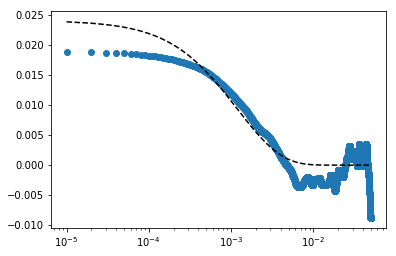

In [46]:
paramsFC = fit_corr_model.make_params()
paramsFC['kappa'].set(value=kappa,vary=False)
paramsFC['sigma'].set(value=sigma,vary=False)
paramsFC['ga'].set(value=ga,vary=False)
paramsFC['eta'].set(value=eta,vary=True)

resultFC = fit_corr_model.fit(t=t,data=autocorr,params=paramsFC)

plt.figure()
plt.semilogx(t,autocorr,"o")
plt.semilogx(t,resultFC.best_fit, 'k--')

print(resultFC.fit_report(min_correl=0.25))